# Chapter 3: MNIST & Titanic

This notebook contains the code for chapter 3 of the Hands-on Machine Learning with Scikit-Learn, Keras & Tensorflow book.

In [1]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_predict, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.base import BaseEstimator, clone
from sklearn.datasets import fetch_openml
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_recall_curve,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)

from scipy.ndimage.interpolation import shift
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np

## Global configuration

In [2]:
MNIST_DATA_NAME = "mnist_784"
MNIST_DATA_VERSION = 1

BASE_PATH = "../data/"
TITANIC_TRAIN_DATA_FILE = BASE_PATH + "titanic_train.csv"
TITANIC_TEST_DATA_FILE = BASE_PATH + "titanic_test.csv"

RANDOM_SEED = 42

JOB_COUNT = 3

In [3]:
np.random.seed(RANDOM_SEED)

## Load data

In [4]:
mnist = fetch_openml(MNIST_DATA_NAME, version=MNIST_DATA_VERSION, as_frame=False)

## Split data

In [5]:
X, y = mnist["data"], mnist["target"]

In [6]:
X.shape, y.shape

((70000, 784), (70000,))

## Clean data

In [7]:
y = y.astype(np.uint8)

## Examine data

(-0.5, 27.5, 27.5, -0.5)

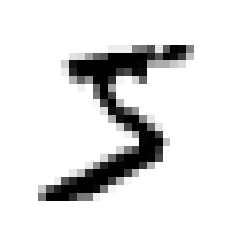

In [8]:
image = X[0].reshape(28, 28)

plt.imshow(image, cmap = mpl.cm.binary, interpolation="nearest")
plt.axis("off")

In [9]:
y[0]

5

## Create train/test split

In [10]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Train <ins>neverfive</ins> model (binary)

In [11]:
y_train_custom = (y_train == 5)
y_test_custom = (y_test == 5)

In [12]:
class NeverFiveClassifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [13]:
never_five_model = NeverFiveClassifier()

In [14]:
%%time
never_five_model.fit(X_train, y_train_custom)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.82 µs


## Evaluate <ins>neverfive</ins> model (cross-validation)

In [15]:
%%time
cross_val_score(never_five_model, X_train, y_train_custom, cv=3, n_jobs=JOB_COUNT, scoring="accuracy")

CPU times: user 236 ms, sys: 204 ms, total: 440 ms
Wall time: 1.19 s


array([0.91125, 0.90855, 0.90915])

## Train <ins>SGD</ins> model (binary)

In [16]:
sgd_model = SGDClassifier(random_state=RANDOM_SEED)

In [17]:
%%time
sgd_model.fit(X_train, y_train_custom)

CPU times: user 19.7 s, sys: 56.4 ms, total: 19.8 s
Wall time: 19.8 s


SGDClassifier(random_state=42)

## Test <ins>SGD</ins> model (binary)

In [18]:
sgd_model.predict([X_train[0]]) == y_train_custom[0]

array([ True])

## Evaluate <ins>SGD</ins> model (cross-validation)

In [19]:
folds = StratifiedKFold(n_splits=3)

for train_index, test_index in folds.split(X_train, y_train_custom):
    clone_model = clone(sgd_model)
    
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_custom[train_index]
    
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_custom[test_index]
    
    clone_model.fit(X_train_folds, y_train_folds)
    
    y_test_predictions = clone_model.predict(X_test_fold)
    correct = sum(y_test_predictions == y_test_fold)
    
    print(correct / len(y_test_predictions))

0.95035
0.96035
0.9604


In [20]:
%%time
cross_val_score(sgd_model, X_train, y_train_custom, cv=3, n_jobs=JOB_COUNT, scoring="accuracy")

CPU times: user 270 ms, sys: 208 ms, total: 478 ms
Wall time: 18.8 s


array([0.95035, 0.96035, 0.9604 ])

## Evaluate <ins>SGD</ins> model (confusion-matrix)

In [21]:
%%time
y_train_custom_predictions = cross_val_predict(sgd_model, X_train, y_train_custom, cv=3, n_jobs=JOB_COUNT)

CPU times: user 252 ms, sys: 220 ms, total: 473 ms
Wall time: 18.6 s


In [22]:
confusion_matrix(y_train_custom, y_train_custom_predictions)

array([[53892,   687],
       [ 1891,  3530]])

In [23]:
confusion_matrix(y_train_custom, y_train_custom)

array([[54579,     0],
       [    0,  5421]])

## Evaluate <ins>SGD</ins> model (precision & recall)

In [24]:
precision_score(y_train_custom, y_train_custom_predictions)

0.8370879772350012

In [25]:
recall_score(y_train_custom, y_train_custom_predictions)

0.6511713705958311

## Evaluate <ins>SGD</ins> model (f1)

In [26]:
f1_score(y_train_custom, y_train_custom_predictions)

0.7325171197343846

## Evaluate <ins>SGD</ins> model (score 1)

In [27]:
threshold = 0

In [28]:
y_score = sgd_model.decision_function([X_test[0]])
y_score

array([-8542.1753957])

In [29]:
y_prediction = (y_score > threshold)
y_prediction

array([False])

In [30]:
threshold = 8000

In [31]:
y_prediction = (y_score > threshold)
y_prediction

array([False])

## Evaluate <ins>SGD</ins> model (score 2)

In [32]:
%%time
y_train_custom_scores = cross_val_predict(
    sgd_model,
    X_train,
    y_train_custom,
    cv=3,
    n_jobs=JOB_COUNT,
    method="decision_function",
)

CPU times: user 256 ms, sys: 196 ms, total: 453 ms
Wall time: 19.5 s


In [33]:
precisions, recalls, thresholds = precision_recall_curve(y_train_custom, y_train_custom_scores)

(-50000.0, 50000.0, 0.0, 1.0)

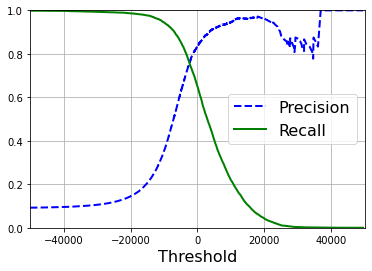

In [34]:
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.legend(loc="center right", fontsize=16)
plt.xlabel("Threshold", fontsize=16)
plt.grid(True)
plt.axis([-50000, 50000, 0, 1])

(0.0, 1.0, 0.0, 1.0)

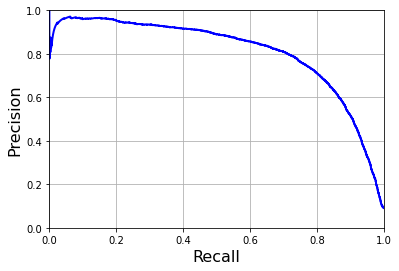

In [35]:
plt.plot(recalls, precisions, "b-", linewidth=2)
plt.xlabel("Recall", fontsize=16)
plt.ylabel("Precision", fontsize=16)
plt.grid(True)
plt.axis([0, 1, 0, 1])

In [36]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

In [37]:
y_train_custom_predictions_90_precision = (y_train_custom_scores >= threshold_90_precision)

In [38]:
precision_score(y_train_custom, y_train_custom_predictions_90_precision)

0.9000345901072293

In [39]:
recall_score(y_train_custom, y_train_custom_predictions_90_precision)

0.4799852425751706

## Evaluate <ins>SGD</ins> model (roc)

In [40]:
sgd_fpr, sgd_tpr, sgd_thresholds = roc_curve(y_train_custom, y_train_custom_scores)

(0.0, 1.0, 0.0, 1.0)

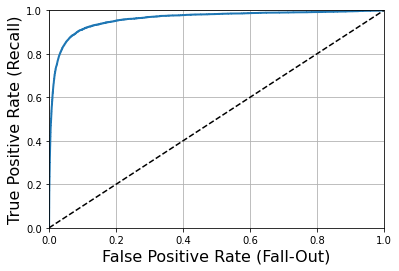

In [41]:
plt.plot(sgd_fpr, sgd_tpr, linewidth=2, label=None)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
plt.ylabel('True Positive Rate (Recall)', fontsize=16)
plt.grid(True)
plt.axis([0, 1, 0, 1])

## Evaluate <ins>SGD</ins> model (auc)

In [42]:
roc_auc_score(y_train_custom, y_train_custom_scores)

0.9604938554008616

## Train <ins>random forest</ins> model (binary)

In [43]:
rf_model = RandomForestClassifier(random_state=RANDOM_SEED)

## Evaluate <ins>random forest</ins> model (score)

In [44]:
%%time
y_train_custom_scores = cross_val_predict(
    rf_model,
    X_train,
    y_train_custom,
    cv=3,
    n_jobs=JOB_COUNT,
    method="predict_proba",
)[:, 1]

CPU times: user 237 ms, sys: 198 ms, total: 435 ms
Wall time: 31.4 s


## Evaluate <ins>random forest</ins> model (roc)

In [45]:
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_train_custom, y_train_custom_scores)

## Compare <ins>SGD</ins> & <ins>random forest</ins> model (roc)

(0.0, 1.0, 0.0, 1.0)

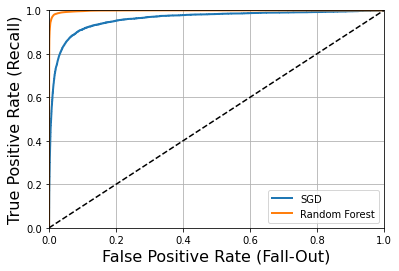

In [46]:
plt.plot(sgd_fpr, sgd_tpr, linewidth=2, label="SGD")
plt.plot(rf_fpr, rf_tpr, linewidth=2, label="Random Forest")
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
plt.ylabel('True Positive Rate (Recall)', fontsize=16)
plt.grid(True)
plt.axis([0, 1, 0, 1])

## Evaluate <ins>random forest</ins> model (auc)

In [47]:
roc_auc_score(y_train_custom, y_train_custom_scores)

0.9983436731328145

## Evaluate <ins>random forest</ins> model (precision & recall)

In [48]:
%%time
y_train_custom_predictions = cross_val_predict(rf_model, X_train, y_train_custom, cv=3, n_jobs=JOB_COUNT)

CPU times: user 252 ms, sys: 228 ms, total: 480 ms
Wall time: 30.6 s


In [49]:
precision_score(y_train_custom, y_train_custom_predictions)

0.9905083315756169

In [50]:
recall_score(y_train_custom, y_train_custom_predictions)

0.8662608374838591

## Transform Data

In [51]:
standard_scaler = StandardScaler()

In [52]:
X_train_scaled = standard_scaler.fit_transform(X_train.astype(np.float64))

## Train <ins>random forest</ins> model (multiclass)

In [53]:
rf_mc_model = RandomForestClassifier(random_state=RANDOM_SEED)

In [54]:
%%time
rf_mc_model.fit(X_train_scaled, y_train)

CPU times: user 39.8 s, sys: 84.3 ms, total: 39.8 s
Wall time: 39.8 s


RandomForestClassifier(random_state=42)

## Test <ins>random forest</ins> model (multiclass)

In [55]:
rf_mc_model.predict([X_train_scaled[0]]) == y_train[0]

array([ True])

## Train <ins>SGD</ins> model (ova-multiclass)

In [56]:
sgd_ova_model = SGDClassifier(random_state=RANDOM_SEED)

In [57]:
%%time
sgd_ova_model.fit(X_train_scaled, y_train)

CPU times: user 6min 34s, sys: 114 ms, total: 6min 34s
Wall time: 6min 34s


SGDClassifier(random_state=42)

## Test <ins>SGD</ins> model (ova-multiclass)

In [58]:
sgd_ova_model.predict([X_train_scaled[0]]) == y_train[0]

array([ True])

In [59]:
sgd_ova_model.classes_[np.argmax(sgd_ova_model.decision_function([X_train_scaled[0]]))]

5

## Train <ins>SGD</ins> model (ovo-multiclass)

In [60]:
sgd_ovo_model = OneVsOneClassifier(SGDClassifier(random_state=RANDOM_SEED))

In [61]:
%%time
sgd_ovo_model.fit(X_train_scaled, y_train)

CPU times: user 38.1 s, sys: 444 ms, total: 38.5 s
Wall time: 38.5 s


OneVsOneClassifier(estimator=SGDClassifier(random_state=42))

## Test <ins>SGD</ins> model (ovo-multiclass)

In [62]:
sgd_ovo_model.predict([X_train_scaled[0]]) == y_train[0]

array([ True])

## Evaluate <ins>SGD</ins> model (ovo-multiclass)

In [63]:
%%time
cross_val_score(sgd_ovo_model, X_train_scaled, y_train, cv=3, n_jobs=JOB_COUNT, scoring="accuracy")

CPU times: user 91.5 ms, sys: 244 ms, total: 336 ms
Wall time: 30.4 s


array([0.91595, 0.9149 , 0.91845])

## Analyse <ins>SGD</ins> errors (ovo-multiclass)

In [64]:
%%time
y_train_predictions = cross_val_predict(sgd_ovo_model, X_train_scaled, y_train, cv=3, n_jobs=JOB_COUNT)

CPU times: user 50.5 ms, sys: 148 ms, total: 199 ms
Wall time: 21.6 s


In [65]:
y_train_matrix = confusion_matrix(y_train, y_train_predictions)

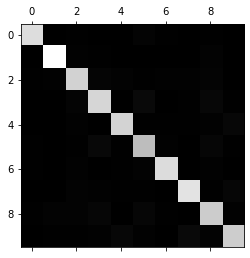

In [66]:
plt.matshow(y_train_matrix, cmap=plt.cm.gray)

In [67]:
y_train_matrix = y_train_matrix / y_train_matrix.sum(axis=1, keepdims=True)

In [68]:
np.fill_diagonal(y_train_matrix, 0)

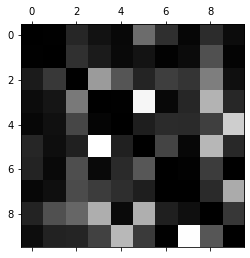

In [69]:
plt.matshow(y_train_matrix, cmap=plt.cm.gray)

## Create multilabel data

In [70]:
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)

y_train_multilabel = np.c_[y_train_large, y_train_odd]

## Train <ins>k nearest neighbours</ins> model (multilabel)

In [71]:
knn_ml_model = KNeighborsClassifier()

In [72]:
%%time
knn_ml_model.fit(X_train, y_train_multilabel)

CPU times: user 36.3 ms, sys: 56 ms, total: 92.3 ms
Wall time: 30.5 ms


KNeighborsClassifier()

## Test <ins>k nearest neighbours</ins> model (multilabel)

In [73]:
knn_ml_model.predict([X_train[0]]) == y_train_multilabel[0]

array([[ True,  True]])

## Evaluate <ins>k nearest neighbours</ins> model (f1)

In [74]:
%%time
y_train_multilabel_predictions = cross_val_predict(
    knn_ml_model,
    X_train,
    y_train_multilabel,
    cv=3,
    n_jobs=JOB_COUNT,
)

CPU times: user 450 ms, sys: 1.26 s, total: 1.71 s
Wall time: 46.7 s


In [75]:
f1_score(y_train_multilabel, y_train_multilabel_predictions, average="macro")

0.976410265560605

## Create multioutput data

In [76]:
noise = np.random.randint(0, 100, (len(X_train), 784))

X_train_noise = X_train + noise
y_train_noise = X_train

noise = np.random.randint(0, 100, (len(X_test), 784))

X_test_noise = X_test + noise
y_test_noise = X_test

## Train <ins>k nearest neighbours</ins> model (multioutput)

In [77]:
knn_mo_model = KNeighborsClassifier()

In [78]:
%%time
knn_mo_model.fit(X_train_noise, y_train_noise)

CPU times: user 4.79 s, sys: 164 ms, total: 4.95 s
Wall time: 4.95 s


KNeighborsClassifier()

## Test <ins>k nearest neighbours</ins> model (multioutput)

In [79]:
prediction = knn_mo_model.predict([X_test_noise[0]])
actual = y_test_noise[0]

(-0.5, 27.5, 27.5, -0.5)

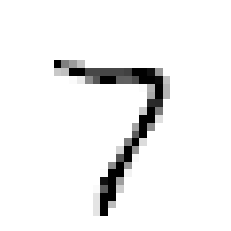

In [80]:
image = prediction.reshape(28, 28)
plt.imshow(image, cmap = mpl.cm.binary, interpolation="nearest")
plt.axis("off")

(-0.5, 27.5, 27.5, -0.5)

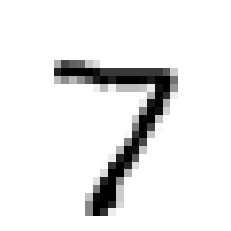

In [81]:
image = actual.reshape(28, 28)
plt.imshow(image, cmap = mpl.cm.binary, interpolation="nearest")
plt.axis("off")

# Exercises

1. Try to build a classifier for the MNIST dataset that achieves over 97% accuracy on the test set. Hint: the KNeighborsClassifier works quite well for this task; you just need to find good hyperparameter values (try a grid search on the weights and n_neighbors hyperparameters).

**Solution**

### Train

In [82]:
parameters = [
    {"weights": ["uniform", "distance"], "n_neighbors": [3, 4, 5]},
]

In [83]:
knn_model = KNeighborsClassifier()

In [84]:
grid_search = GridSearchCV(knn_model, parameters, cv=5, n_jobs=JOB_COUNT)

In [85]:
%%time
grid_search.fit(X_train, y_train)

CPU times: user 284 ms, sys: 173 ms, total: 457 ms
Wall time: 4min 11s


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=3,
             param_grid=[{'n_neighbors': [3, 4, 5],
                          'weights': ['uniform', 'distance']}])

In [86]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [87]:
grid_search.best_estimator_

KNeighborsClassifier(n_neighbors=4, weights='distance')

### Performance

In [88]:
%%time
y_test_predictions = grid_search.predict(X_test)

CPU times: user 1min 32s, sys: 1min 29s, total: 3min 1s
Wall time: 20.1 s


In [89]:
accuracy_score(y_test, y_test_predictions)

0.9714

2. Write a function that can shift an MNIST image in any direction (left, right, up, or down) by one pixel.5 Then, for each image in the training set, create four shifted copies (one per direction) and add them to the training set. Finally, train your best model on this expanded training set and measure its accuracy on the test set. You should observe that your model performs even better now! This technique of artificially growing the training set is called data augmentation or training set expansion.

**Solution**

### Prepare

In [90]:
def shift_image(image, dx, dy):
    original_image = image.reshape((28, 28))
    shifted_image = shift(original_image, [dy, dx], cval=0, mode="constant")
    
    return shifted_image.reshape([-1])

In [91]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [92]:
shuffled = np.random.permutation(len(X_train_augmented))

X_train_augmented = X_train_augmented[shuffled]
y_train_augmented = y_train_augmented[shuffled]

### Train

In [93]:
knn_model = KNeighborsClassifier(**grid_search.best_params_)

In [94]:
%%time
knn_model.fit(X_train_augmented, y_train_augmented)

CPU times: user 128 ms, sys: 71 µs, total: 128 ms
Wall time: 128 ms


KNeighborsClassifier(n_neighbors=4, weights='distance')

### Performance

In [95]:
%%time
y_test_predictions = knn_model.predict(X_test)

CPU times: user 10min 22s, sys: 6min 31s, total: 16min 54s
Wall time: 1min 55s


In [96]:
accuracy_score(y_test, y_test_predictions)

0.9763

3. Tackle the Titanic dataset. A great place to start is on Kaggle.

**Solution**

### Load

In [97]:
def load_titanic_data():
    train_set = pd.read_csv(TITANIC_TRAIN_DATA_FILE)
    test_set = pd.read_csv(TITANIC_TEST_DATA_FILE)
    
    return train_set, test_set

In [98]:
train_set, test_set = load_titanic_data()

### Inspect

In [99]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [100]:
train_set.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [101]:
train_set.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Prepare (numerical)

In [102]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.attribute_names]

In [103]:
numerical_pipeline = Pipeline([
    ("dataframe_selector", DataFrameSelector(["Age", "SibSp", "Parch", "Fare"])),
    ("simple_imputer", SimpleImputer(strategy="median")),
])

In [104]:
numerical_pipeline.fit_transform(train_set)

array([[22.    ,  1.    ,  0.    ,  7.25  ],
       [38.    ,  1.    ,  0.    , 71.2833],
       [26.    ,  0.    ,  0.    ,  7.925 ],
       ...,
       [28.    ,  1.    ,  2.    , 23.45  ],
       [26.    ,  0.    ,  0.    , 30.    ],
       [32.    ,  0.    ,  0.    ,  7.75  ]])

### Prepare (categorical)

In [105]:
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X], index=X.columns)
        return self
    
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

In [106]:
categorical_pipeline = Pipeline([
    ("dataframe_selector", DataFrameSelector(["Pclass", "Sex", "Embarked"])),
    ("most_frequent_imputer", MostFrequentImputer()),
    ("one_hot_encoder", OneHotEncoder(sparse=False)),
])

In [107]:
categorical_pipeline.fit_transform(train_set)

array([[0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.]])

### Prepare (all)

In [108]:
preprocess_pipeline = FeatureUnion(transformer_list=[
    ("numerical_pipeline", numerical_pipeline),
    ("categorical_pipeline", categorical_pipeline),
])

In [109]:
X_train = preprocess_pipeline.fit_transform(train_set)
X_train

array([[22.,  1.,  0., ...,  0.,  0.,  1.],
       [38.,  1.,  0., ...,  1.,  0.,  0.],
       [26.,  0.,  0., ...,  0.,  0.,  1.],
       ...,
       [28.,  1.,  2., ...,  0.,  0.,  1.],
       [26.,  0.,  0., ...,  1.,  0.,  0.],
       [32.,  0.,  0., ...,  0.,  1.,  0.]])

In [110]:
y_train = train_set["Survived"]

### Train (SVC)

In [111]:
svc_model = SVC(gamma="auto")

In [112]:
%%time
svc_model.fit(X_train, y_train)

CPU times: user 32 ms, sys: 100 µs, total: 32.1 ms
Wall time: 34.8 ms


SVC(gamma='auto')

### Performance (SVC)

In [113]:
%%time
scores = cross_val_score(svc_model, X_train, y_train, cv=10, n_jobs=JOB_COUNT)

CPU times: user 12.3 ms, sys: 3.96 ms, total: 16.3 ms
Wall time: 670 ms


In [114]:
scores.mean()

0.7329588014981274

### Train (random forest)

In [115]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED)

In [116]:
%%time
rf_model.fit(X_train, y_train)

CPU times: user 120 ms, sys: 552 µs, total: 121 ms
Wall time: 122 ms


RandomForestClassifier(random_state=42)

### Performance (random forest)

In [117]:
%%time
scores = cross_val_score(rf_model, X_train, y_train, cv=10, n_jobs=JOB_COUNT)

CPU times: user 13.6 ms, sys: 0 ns, total: 13.6 ms
Wall time: 572 ms


In [118]:
scores.mean()

0.8126466916354558